# Weight truncation in UniFold/MultiFold

Make sure to comment out the `np.nan_to_num` and/or `np.clip` functions in the respective functions you're analyzing before running!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Generic imports
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator
import json 

### ML imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import tensorflow as tf

### Custom functions
from omnifold import *
from omnifold.utilities import *

In [3]:
! nvidia-smi -L # list GPUs available

GPU 0: Quadro RTX 6000 (UUID: GPU-26dfa6b3-88ef-1e87-ba91-3ca0255166ab)
GPU 1: Quadro RTX 6000 (UUID: GPU-2c315734-0ffc-e8d8-40fb-29a2ccd25ab5)
GPU 2: Quadro RTX 6000 (UUID: GPU-057fcb77-7816-2825-8db8-b78905930b06)
GPU 3: Quadro RTX 6000 (UUID: GPU-dc56feb4-523f-6ded-e577-4416c9dc6561)


In [4]:
### GPU Setup
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-01-26 12:32:16.103587: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-26 12:32:16.138056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-26 12:32:16.138489: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-26 12:32:16.140354: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-26 12:32:16.142201: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-26 12:32:16.142478: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

In [5]:
plot_setup()
plt.rcParams.update({"font.family": "serif",})

In [6]:
plot_dir = './plots/'

### Load files

In [7]:
mc = pd.read_hdf('./omnifold_data/zjets_powhegpythia_mc16e.h5')
data = pd.read_hdf('./omnifold_data/zjets_sherpa_mc16e.h5')
data_truth = pd.read_hdf('./omnifold_data/zjets_sherpa_mc16e_truth.h5')

with open(r'./omnifold_data/inputs.json', "r") as read_file:
    inputs = json.load(read_file)
    
for dict in inputs:
    dict['bins'] = np.asarray(dict['bins']) # cast back to numpy arrays for plotting
    
### Add in 200 GeV cuts for plotting only 
mc_pt200 = mc[(mc.truth_pT_ll > 200) | (mc.pT_ll > 200)]
data_truth_pt200 = data_truth[data_truth.truth_pT_ll > 200]
data_pt200 = data[data.pT_ll > 200]
mc_filter = (mc.truth_pT_ll > 200) | (mc.pT_ll > 200)

dummyval = -99
save_label0 = 'weight_study'

# UniFold

### Apply unfolding

In [16]:
K.clear_session()

In [17]:
i = 0 # index of variable of interest (0 = n_tracks for leading jet)

In [18]:
save_label0 = 'example'
bins = ibu_hists[i]['bins']
x_label = ibu_hists[i]['plot_label']
file_label = ibu_hists[i]['file_label']
os.makedirs(plot_dir+'UniFold/'+file_label, exist_ok=True)
save_label = plot_dir+'UniFold/'+file_label+'/'+save_label0
print("Saving as {}.".format(save_label))

Saving as ./plots/UniFold/Ntracks_trackj1/example.


Grab the particular variable you care about, and set a dummy value for events that don't pass each MC selection:

In [19]:
dummyval = -99
mc['truth_var'] = np.where(mc.truth_pass190, mc['truth_'+file_label], dummyval)
mc['reco_var'] = np.where(mc.pass190, mc[file_label], dummyval)
data_truth['truth_var'] = data_truth['truth_'+file_label]
data['reco_var'] = data[file_label]

/tmp/ipykernel_19879/2058628029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_truth['truth_var'] = data_truth['truth_'+file_label]


In [20]:
# # artificially shift MC distribution to induce infinite weights
# offset = 30
# mc.truth_var += offset
# # mc.reco_var += offset

In [21]:
# mc.truth_var.replace(dummyval+offset, dummyval, inplace=True)

Plot this observable in MC & "data" before unfolding:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


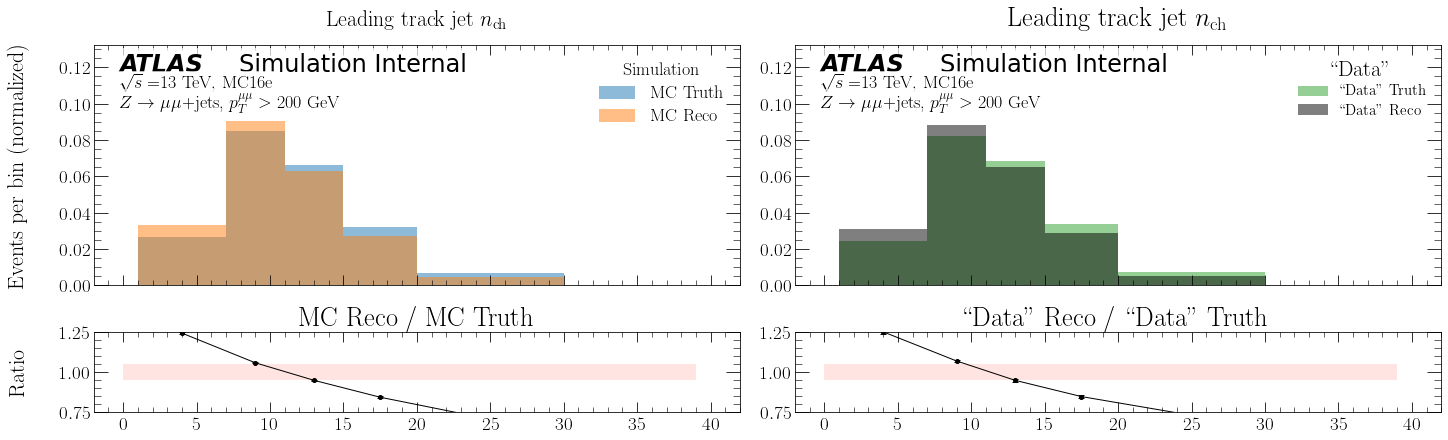

In [22]:
### Add in 200 GeV cuts for plotting only 
mc_plots = mc[(mc.truth_pT_ll > 200) | (mc.pT_ll > 200)]
data_truth_plots = data_truth[data_truth.truth_pT_ll > 200]
data_plots = data[data.pT_ll > 200]

omnifold_weights = np.zeros(shape=(len(ibu_hists), len(mc_plots))) # the right size for the 200 GeV cut

plot_distributions(
    sim_truth=mc_plots.truth_var,
    sim_reco=mc_plots.reco_var,
    sim_truth_weights_MC=mc_plots.weight_mc,
    sim_reco_weights_MC=mc_plots.weight,
    data_truth=data_truth_plots.truth_var,
    data_reco=data_plots.reco_var,
    data_truth_weights_MC=data_truth_plots.weight_mc,
    data_reco_weights_MC=data_plots.weight,
    bins=bins,
    x_label=x_label,
    save_label=save_label
)

Standardize the data by z-score:

In [23]:
mc_truth_z, mc_reco_z, data_reco_z = standardize(np.array(mc.truth_var), np.array(mc.reco_var), np.array(data.reco_var))

Unfold!

In [24]:
weights, _ = unifold(iterations=3,
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc.weight_mc,
                     sim_reco_weights_MC=mc.weight,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data.weight,
                     dummyval=dummyval,
                     verbose=0,
                    )

2022-01-25 23:39:37.661653: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-01-25 23:39:37.670501: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2994530000 Hz
2022-01-25 23:39:37.671819: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55968b4aeb80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-25 23:39:37.671850: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-25 23:39:37.772561: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55968705a770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-01-25 23:39:37.772614: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2022-01-25 23:39:37.773718: I 

In [25]:
weights.shape # (n_iterations, n_steps, n_events)

(3, 2, 416725)

In [26]:
print(weights.min())
print(weights.max())

0.035753488540649414
11.974466323852539


In [27]:
weights

array([[[0.94793522, 0.96813715, 0.96389312, ..., 0.96389312,
         0.96417141, 1.07616174],
        [0.95606226, 0.950046  , 0.96807069, ..., 0.96841186,
         0.97854054, 1.07924831]],

       [[0.95618039, 0.96175158, 0.97568583, ..., 0.97602975,
         0.98795909, 1.03832793],
        [0.95588648, 0.95075977, 0.96975249, ..., 0.98502034,
         0.99846107, 1.02910578]],

       [[0.9388268 , 0.92213362, 0.96659636, ..., 0.9818145 ,
         0.98678738, 1.07329142],
        [0.93311286, 0.92404294, 0.96544158, ..., 0.97812146,
         0.99296325, 1.07509804]]])

In [28]:
weights[:,0] # step 1 weights for each iteration

array([[0.94793522, 0.96813715, 0.96389312, ..., 0.96389312, 0.96417141,
        1.07616174],
       [0.95618039, 0.96175158, 0.97568583, ..., 0.97602975, 0.98795909,
        1.03832793],
       [0.9388268 , 0.92213362, 0.96659636, ..., 0.9818145 , 0.98678738,
        1.07329142]])

In [29]:
np.isnan(weights[0,0]).sum()

0

In [30]:
len(weights[0,0])

416725

In [31]:
# fraction of NaN weights for step 1, iteration 1
100*np.isnan(weights[0,0]).sum()/len(weights[0,0])

0.0

In [32]:
weights[:,1] # step 2 weights for each iteration

array([[0.95606226, 0.950046  , 0.96807069, ..., 0.96841186, 0.97854054,
        1.07924831],
       [0.95588648, 0.95075977, 0.96975249, ..., 0.98502034, 0.99846107,
        1.02910578],
       [0.93311286, 0.92404294, 0.96544158, ..., 0.97812146, 0.99296325,
        1.07509804]])

In [33]:
# fraction of NaN weights for step 2, iteration 1
100*np.isnan(weights[0,1]).sum()/len(weights[0,1])

0.0

In [34]:
np.isnan(weights[0,1]).sum()

0

In [35]:
# fraction of weights that are NaNs
np.isnan(weights).sum()/(weights.shape[0]*weights.shape[1]*weights.shape[2])

0.0

In [36]:
# fraction of weights that are non-NaN
np.count_nonzero(~np.isnan(weights))/(weights.shape[0]*weights.shape[1]*weights.shape[2])

1.0

In [37]:
array = weights[:,1].flatten()

In [38]:
array

array([0.95606226, 0.950046  , 0.96807069, ..., 0.97812146, 0.99296325,
       1.07509804])

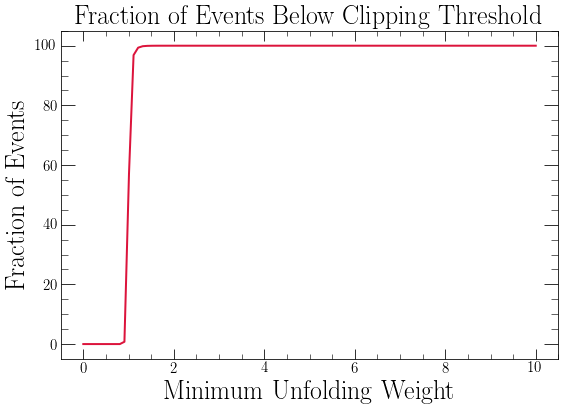

In [39]:
fractions = []
for x in np.linspace(0,10,100): 
    fractions.append(100*(array < x).sum()/len(array))
    
plt.plot(np.linspace(0,10,100),fractions, linewidth=2, color='crimson')
plt.title("Fraction of Events Below Clipping Threshold", fontsize=26)
plt.xlabel("Minimum Unfolding Weight", fontsize=26, labelpad=5)
plt.ylabel("Fraction of Events", fontsize=26, labelpad=5);

Store the weights for the dataset that passes 200 GeV:

In [40]:
filter = (mc.truth_pT_ll > 200) | (mc.pT_ll > 200)

omnifold_weights[i] = best_1D_reweighting(
    test=mc_plots.reco_var,
    test_weights=np.array(mc_plots.weight) * weights[:,:,filter][:,1],
    target=data_plots.reco_var,
    target_weights=data_plots.weight,
    bins=bins)

In [41]:
omnifold_weights[i].min()

-2.4629165886991586

In [42]:
omnifold_weights[i].max()

3.243274790483156

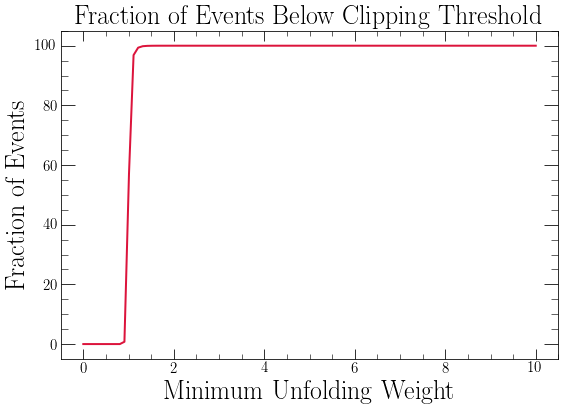

In [43]:
fractions = []
for x in np.linspace(0,10,100): 
    fractions.append(100*(array < x).sum()/len(array))
    
plt.plot(np.linspace(0,10,100),fractions, linewidth=2, color='crimson')
plt.title("Fraction of Events Below Clipping Threshold", fontsize=26)
plt.xlabel("Minimum Unfolding Weight", fontsize=26, labelpad=5)
plt.ylabel("Fraction of Events", fontsize=26, labelpad=5);

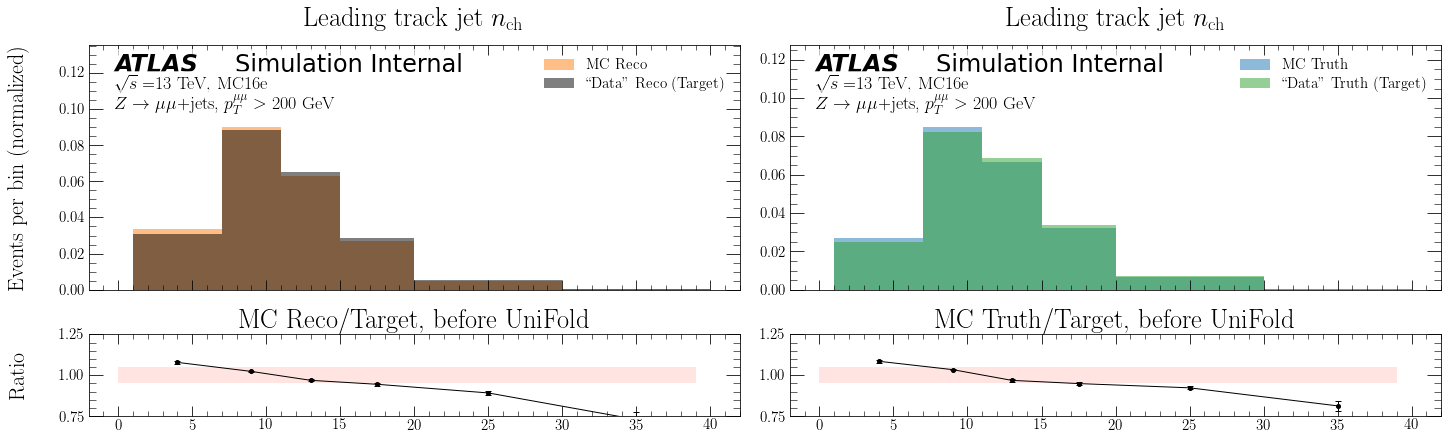

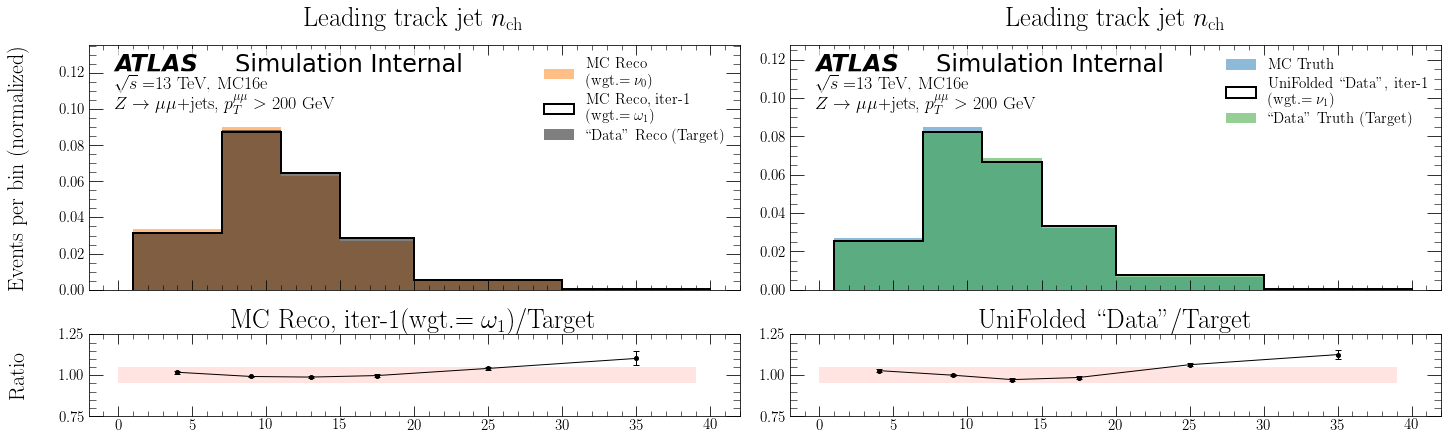

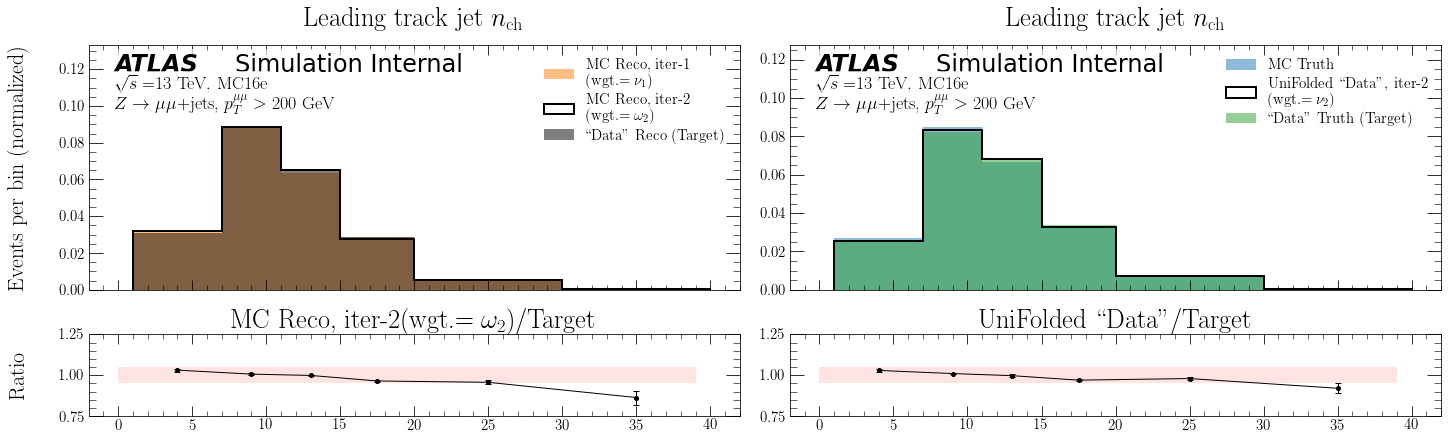

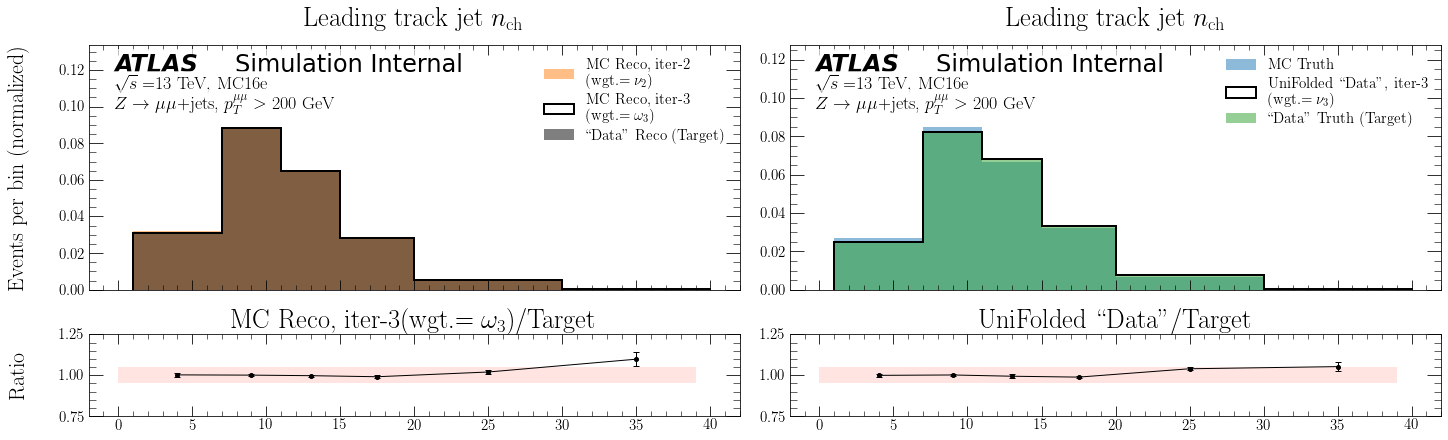

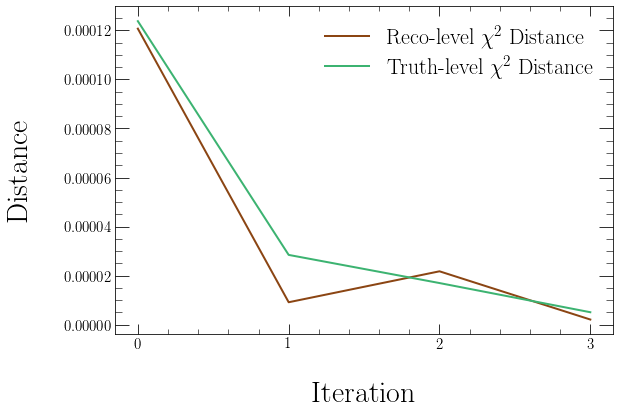

In [44]:
plot_results(sim_truth=mc_plots.truth_var,
             sim_reco=mc_plots.reco_var,
             sim_truth_weights_MC=mc_plots.weight_mc,
             sim_reco_weights_MC=mc_plots.weight,
             data_truth=data_truth_plots.truth_var,
             data_reco=data_plots.reco_var,
             data_truth_weights_MC=data_truth_plots.weight_mc,
             data_reco_weights_MC=data_plots.weight,
             weights=weights[:,:,filter],
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label
            )

# MultiFold

In [8]:
K.clear_session()
print("Unfolding {} variables.".format(len(inputs)))

for dict in inputs:
    dict['bins'] = np.asarray(dict['bins']) # cast back to numpy arrays for plotting

Unfolding 24 variables.


In [9]:
mc_truth_plots = [None] * len(inputs)
mc_reco_plots = [None] * len(inputs)
data_truth_plots = [None] * len(inputs)
data_reco_plots = [None] * len(inputs)

mc_truth_hists = [None] * len(inputs)
mc_reco_hists = [None] * len(inputs)
data_truth_hists = [None] * len(inputs)
data_reco_hists = [None] * len(inputs)

# z-score standardization of data
mc_truth_z = [None] * len(inputs)
mc_reco_z = [None] * len(inputs)
data_reco_z = [None] * len(inputs)

for i in tqdm(range(len(inputs))):
    file_label = inputs[i]['file_label']
    
    mc_truth_plots[i] = np.where(mc_pt200.truth_pass190, mc_pt200['truth_'+file_label], dummyval)
    mc_reco_plots[i] = np.where(mc_pt200.pass190, mc_pt200[file_label], dummyval)
    data_truth_plots[i] = data_truth_pt200['truth_'+file_label]
    data_reco_plots[i] = data_pt200[file_label]
    
    bins = inputs[i]['bins']
    x_label = inputs[i]['plot_label']
    file_label = inputs[i]['file_label']
    os.makedirs(plot_dir+'MultiFold/'+file_label, exist_ok=True)
    save_label = plot_dir+'MultiFold/'+file_label+'/'+save_label0
    
    mc_truth_hists[i] = np.where(mc.truth_pass190, mc['truth_'+file_label], dummyval)
    mc_reco_hists[i] = np.where(mc.pass190, mc[file_label], dummyval)
    data_truth_hists[i] = data_truth['truth_'+file_label]
    data_reco_hists[i] = data[file_label]
    
    mc_truth_z[i], mc_reco_z[i], data_reco_z[i] = standardize(
        np.array(mc_truth_hists[i]), 
        np.array(mc_reco_hists[i]), 
        np.array(data_reco_hists[i]))

#     plot_distributions(
#         sim_truth=mc_truth_plots[i],
#         sim_reco=mc_reco_plots[i],
#         sim_truth_weights_MC=mc_pt200.weight_mc,
#         sim_reco_weights_MC=mc_pt200.weight,
#         data_truth=data_truth_plots[i],
#         data_reco=data_reco_plots[i],
#         data_truth_weights_MC=data_truth_pt200.weight_mc,
#         data_reco_weights_MC=data_pt200.weight,
#         bins=bins,
#         x_label=x_label,
#         save_label=save_label
#     )

100%|██████████| 24/24 [00:02<00:00, 11.07it/s]


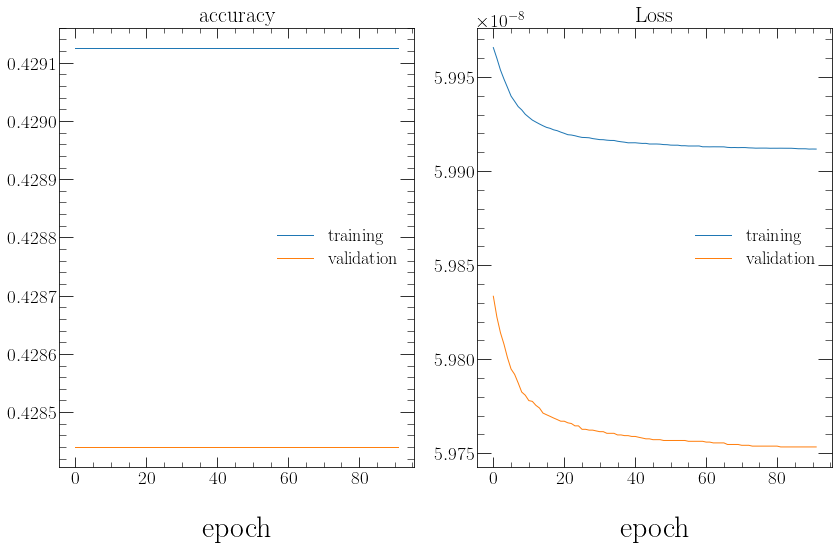

Iterations: 100%|██████████| 5/5 [35:03<00:00, 420.68s/it]

accuracy
	training         	 (min:    0.429, max:    0.429, cur:    0.429)
	validation       	 (min:    0.428, max:    0.428, cur:    0.428)
Loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Finished in 2106.031867980957 seconds.


In [10]:
import time
t0 = time.time()

weights, model = multifold(
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc.weight_mc,
                     sim_reco_weights_MC=mc.weight,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data.weight,
                     dummyval=dummyval,
                     verbose=0,
                     iterations=5,
                     layer_size=200,
                     n_layers=3,
                     epochs=1000,
                     patience=10,
                     batch_size=1000,
                     livelossplot=True,
                     hpo=False,
                    )

print("Finished in {} seconds.".format(time.time() - t0))

In [11]:
weights.shape # (n_iterations, n_steps, n_events)

(5, 2, 416725)

In [12]:
array = weights[:,1,:].flatten() # step 2 weights for all iterations

In [14]:
len([weight for weight in array if weight < 100])/len(array)

0.9986648269242306

In [16]:
# fraction of NaN weights for step 1, iteration 1
100*np.isnan(weights[0,0]).sum()/len(weights[0,0])

0.0

In [17]:
array = weights[:,1,:].flatten() # step 2 weights for all iterations
range = np.linspace(0,10,100) 
fractions = []
for x in range: 
    fractions.append(100*len([weight for weight in array if weight < x])/len(array))
    # fractions.append(100*(array < x).sum()/len(array))
print("{:.3f}% of events have |weight| < 100.".format(fractions[-1]))
print("{:.3f}% of events have |weight| >= 100.".format(100-fractions[-1]))

99.437% of events have |weight| < 100.
0.563% of events have |weight| >= 100.


In [32]:
multifold_weights = weights[-1,-1,:]

In [33]:
multifold_weights.shape

(416725,)

In [36]:
len(mc)

416725

In [38]:
range = np.linspace(0,10,100) 
fractions = []
for x in range: 
    fractions.append(100*len([weight for weight in multifold_weights if weight < x])/len(multifold_weights))
print("{:.3f}% of events have |weight| < 100.".format(fractions[-1]))
print("{:.3f}% of events have |weight| >= 100.".format(100-fractions[-1]))

99.678% of events have |weight| < 100.
0.322% of events have |weight| >= 100.


In [41]:
mc['multifold_weight'] = multifold_weights

In [56]:
mc.keys()

Index(['weight', 'pass190', 'truth_pass190', 'weight_mc', 'prw', 'pT_ll',
       'pT_l1', 'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2', 'y_ll',
       'pT_trackj1', 'y_trackj1', 'phi_trackj1', 'm_trackj1', 'tau1_trackj1',
       'tau2_trackj1', 'tau3_trackj1', 'pT_trackj2', 'y_trackj2',
       'phi_trackj2', 'm_trackj2', 'tau1_trackj2', 'tau2_trackj2',
       'tau3_trackj2', 'truth_pT_ll', 'truth_pT_l1', 'truth_pT_l2',
       'truth_eta_l1', 'truth_eta_l2', 'truth_phi_l1', 'truth_phi_l2',
       'truth_y_ll', 'truth_pT_trackj1', 'truth_y_trackj1',
       'truth_phi_trackj1', 'truth_m_trackj1', 'truth_tau1_trackj1',
       'truth_tau2_trackj1', 'truth_tau3_trackj1', 'truth_pT_trackj2',
       'truth_y_trackj2', 'truth_phi_trackj2', 'truth_m_trackj2',
       'truth_tau1_trackj2', 'truth_tau2_trackj2', 'truth_tau3_trackj2',
       'EventNumber', 'RunNumber', 'Ntracks', 'Ntracks_trackj1',
       'Ntracks_trackj2', 'truth_Ntracks', 'truth_Ntracks_trackj1',
       'truth_Ntracks_trackj2',

In [112]:
inputs

[{'file_label': 'Ntracks_trackj1',
  'plot_label': 'Leading track jet $n_{\\textrm{ch}}$ ',
  'bins': array([ 1,  7, 11, 15, 20, 30, 40])},
 {'file_label': 'Ntracks_trackj2',
  'plot_label': 'Subleading track jet $n_{\\textrm{ch}}$',
  'bins': array([ 1.,  2.,  3.,  5.,  7.,  9., 11., 15., 20., 30., 50., 85.])},
 {'file_label': 'm_trackj1',
  'plot_label': 'Leading track jet $m$ [GeV]',
  'bins': array([ 0., 10., 20., 30., 40., 80.])},
 {'file_label': 'm_trackj2',
  'plot_label': 'Subleading track jet $m$ [GeV]',
  'bins': array([ 0. ,  2.5,  5. , 10. , 20. , 70. ])},
 {'file_label': 'pT_trackj1',
  'plot_label': 'Leading track jet $p_T$ [GeV]',
  'bins': array([   0,   50,  100,  150,  200,  300, 1000])},
 {'file_label': 'pT_trackj2',
  'plot_label': 'Subleading track jet $p_T$ [GeV]',
  'bins': array([  0.,  25.,  50., 100., 700.])},
 {'file_label': 'y_trackj1',
  'plot_label': 'Leading track jet $y$',
  'bins': array([-2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 ,
  

In [130]:
mc.keys()

Index(['weight', 'pass190', 'truth_pass190', 'weight_mc', 'prw', 'pT_ll',
       'pT_l1', 'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2', 'y_ll',
       'pT_trackj1', 'y_trackj1', 'phi_trackj1', 'm_trackj1', 'tau1_trackj1',
       'tau2_trackj1', 'tau3_trackj1', 'pT_trackj2', 'y_trackj2',
       'phi_trackj2', 'm_trackj2', 'tau1_trackj2', 'tau2_trackj2',
       'tau3_trackj2', 'truth_pT_ll', 'truth_pT_l1', 'truth_pT_l2',
       'truth_eta_l1', 'truth_eta_l2', 'truth_phi_l1', 'truth_phi_l2',
       'truth_y_ll', 'truth_pT_trackj1', 'truth_y_trackj1',
       'truth_phi_trackj1', 'truth_m_trackj1', 'truth_tau1_trackj1',
       'truth_tau2_trackj1', 'truth_tau3_trackj1', 'truth_pT_trackj2',
       'truth_y_trackj2', 'truth_phi_trackj2', 'truth_m_trackj2',
       'truth_tau1_trackj2', 'truth_tau2_trackj2', 'truth_tau3_trackj2',
       'EventNumber', 'RunNumber', 'Ntracks', 'Ntracks_trackj1',
       'Ntracks_trackj2', 'truth_Ntracks', 'truth_Ntracks_trackj1',
       'truth_Ntracks_trackj2',

In [141]:
big_weights.pT_trackj1.mean()

129.19072

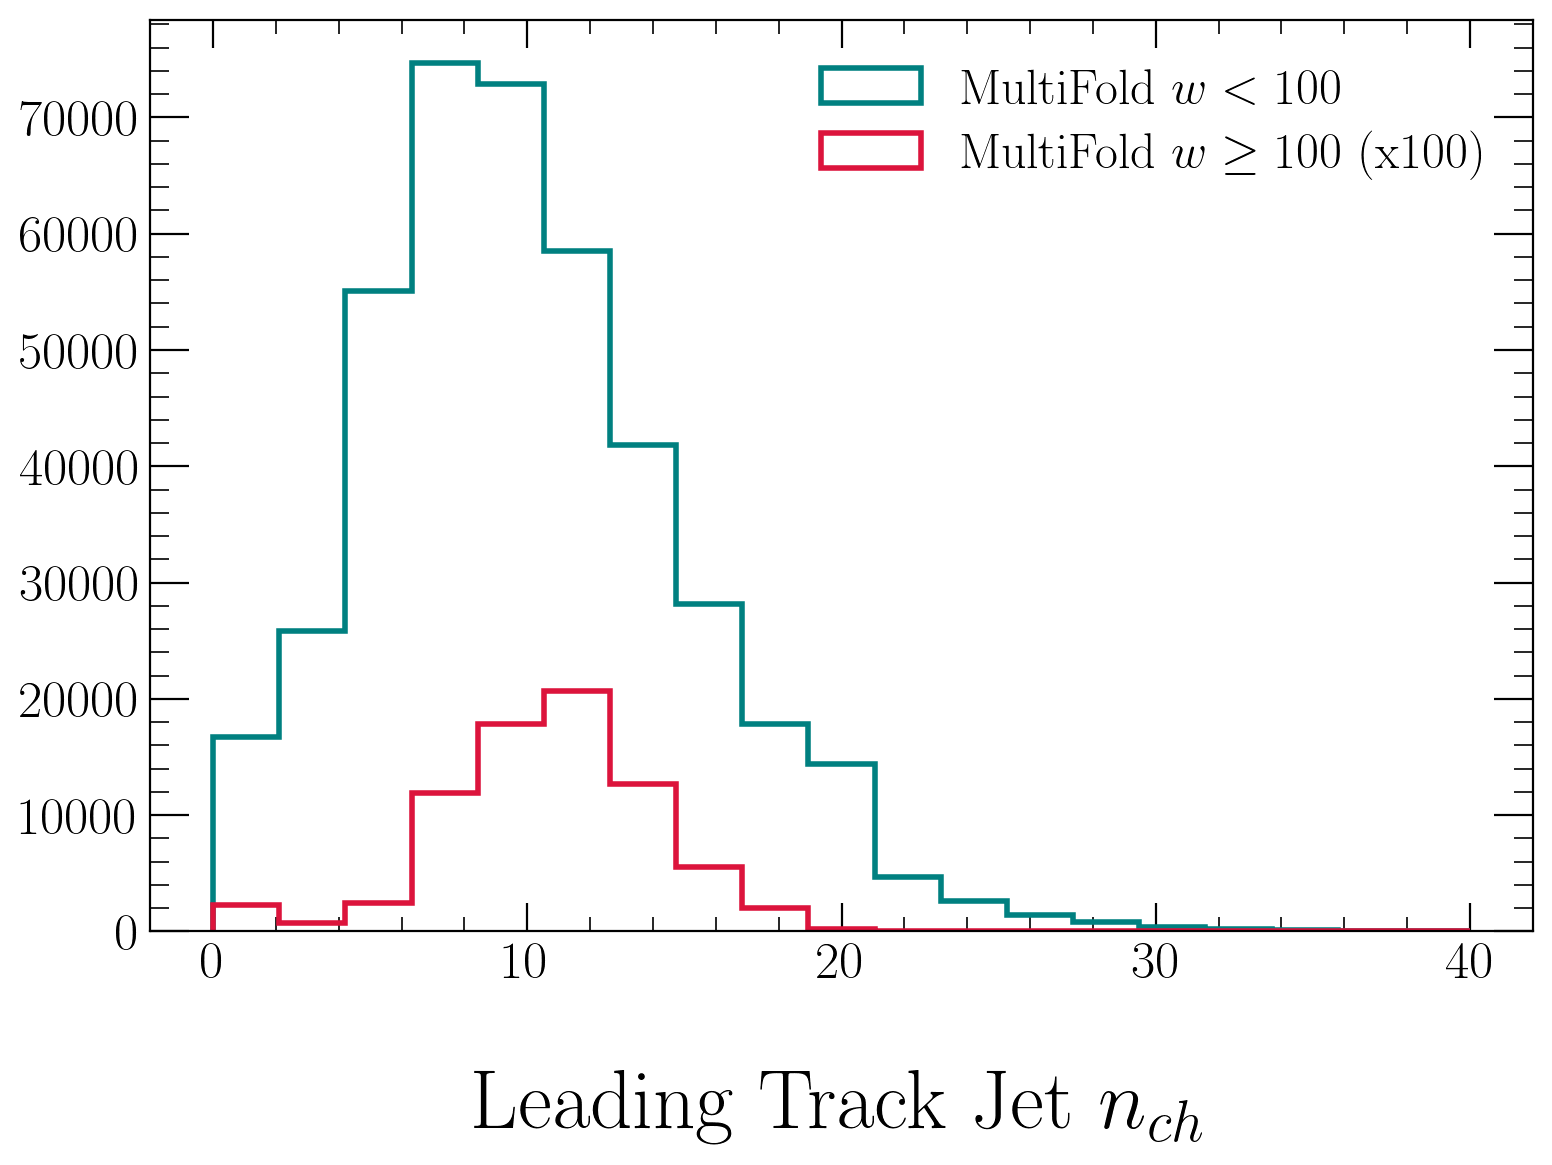

In [140]:
plt.figure(dpi=200)
bins=np.linspace(0,40,20)
plt.hist(small_weights.Ntracks_trackj1, bins=bins, 
         weights=small_weights.weight,
         label=r"MultiFold $w<100$", color="teal",
        linewidth=2,
        histtype="step");
plt.hist(big_weights.Ntracks_trackj1, bins=bins, label=r"MultiFold $w\geq100$ (x100)", 
         linewidth=2,
         histtype="step",
         color="crimson",
         weights=200*big_weights.weight);
# plt.yscale('log');
plt.xlabel(r'Leading Track Jet $n_{ch}$')
plt.legend();

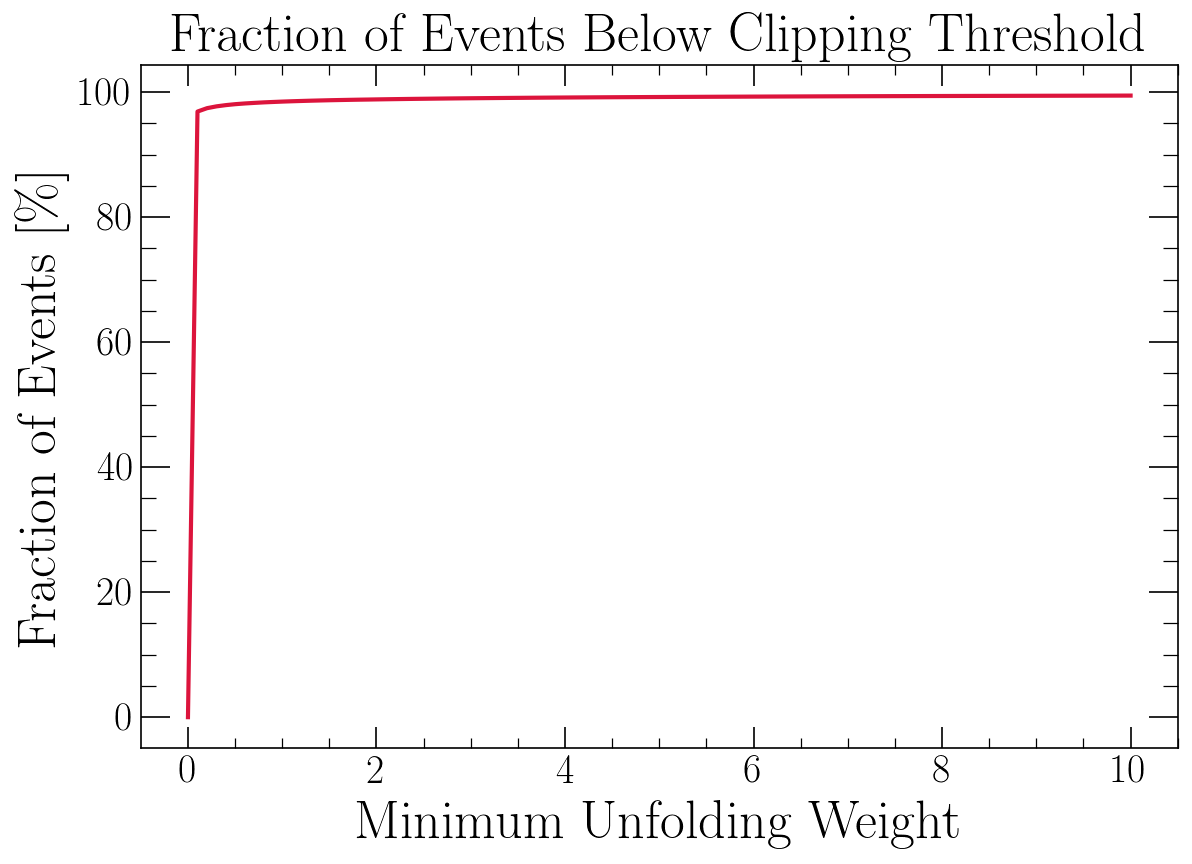

In [18]:
plt.figure(dpi=150)
plt.plot(range,fractions, linewidth=2, color='crimson')
plt.title("Fraction of Events Below Clipping Threshold", fontsize=26)
plt.xlabel("Minimum Unfolding Weight", fontsize=26, labelpad=5)
plt.ylabel("Fraction of Events [\%]", fontsize=26, labelpad=5);
# plt.savefig("./plots/MultiFold/clipping.pdf",bbox_inches='tight',backend='pgf')

In [ ]:
# Okay let's do this a few times and average... 

frac_list = []

for i in np.arange(10):
    weights, _ = multifold(iterations=5,
                           sim_truth=sim_truth_z,
                           sim_reco=sim_reco_z,
                           sim_truth_weights_MC=mc.weight_mc,
                           sim_reco_weights_MC=mc.weight,
                           data_reco=data_reco_z,
                           data_reco_weights_MC=data.weight,
                           dummyval=dummyval,
                           verbose=0)

    frac_list.append(100*np.isnan(weights[0,0]).sum()/len(weights[0,0]))

Iterations::   0%|          | 0/5 [00:00<?, ?it/s]/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/multifold.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)
Iterations::  40%|████      | 2/5 [01:01<01:29, 29.93s/it]/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/multifold.py:194: RuntimeWarning: invalid value encountered in multiply
  weights_pull = weights_push * reweight(model, sim_reco)
Iterations::   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
print(frac_list)

In [ ]:
actual_frac_list = [frac for frac in frac_list if frac < 100]

In [ ]:
np.mean(actual_frac_list)

In [ ]:
filter = (mc.truth_pT_ll > 200) | (mc.pT_ll > 200)

for i in range(len(ibu_hists)):
    print(ibu_hists[i]['file_label'] + " Results\n")
    bins = ibu_hists[i]['bins']
    x_label = ibu_hists[i]['plot_label']
    file_label = ibu_hists[i]['file_label']
    save_label = plot_dir + '/MultiFold/' + file_label + '/' + save_label0 + '-MultiFold-' + file_label

    plot_results(sim_truth=mc_truth_plots[i],
                 sim_reco=mc_reco_plots[i],
                 sim_truth_weights_MC=mc_pt200.weight_mc,
                 sim_reco_weights_MC=mc_pt200.weight,
                 data_truth=data_truth_plots[i],
                 data_reco=data_reco_plots[i],
                 data_truth_weights_MC=data_truth_pt200.weight_mc,
                 data_reco_weights_MC=data_pt200.weight,
                 weights=weights[:,:,filter],
                 bins=bins,
                 x_label=x_label,
                 flavor_label='MultiFold',
                 save_label=save_label)